In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal
from scipy.special import gammaln,gamma
from math import log, floor, exp

import warnings
warnings.filterwarnings('ignore')

####  Recall, generalised Morse defined as:
Morse defined as:

${\psi_{\beta,\gamma}(\omega)}  =  \int_{-\infty}^{\infty} \psi_{\beta,\gamma}(t)e^{-i\omega t} dt  =  U(\omega) a_{\beta,\gamma} \omega^{\beta}e^{-\omega^{\gamma}}$

- ${U(\omega)}$: Heaviside step function
- $a_{\beta,\gamma}$: real valued normalising constant ($a_{\beta,\gamma} = 2 \big( \frac{e\gamma}{\beta} \big)^{\frac{\beta}{\gamma}}$, where $e$ is the Euler number)
- $\beta$ and $\gamma$ controls the wavelet shape

#### functions to generate Morse wavelet explained in morse1D_func notebook

In [2]:
#apply boubdary conditions to data before transform 
#here as zero padding (no detrending of data) - need to implement periodic data 

def zero_pad(x):
    
    #get original length of data
    sizex = np.size(x)
    M=sizex
    
    #get index of first and last value of original data 
    #need to change to account for NaNs in data (e.g where there is topo)
    
    a = 0
    b=len(x)
    
    y = np.zeros(sizex*3)
    
    index=np.arange(a,b)
    indexy= np.arange(M+a-len(index), M + (2*len(index)) + a)
    
    #pad with zeros 
    y[indexy] = np.concatenate((0*x,x,0*x))
    
    return(y)


In [3]:
# compute dimensionless time-domain window width (p) 
def morseprops(ga,be):
    p = np.sqrt(be*ga)
    skew = (ga-3)/p
    kurt = (3-skew)**2 - (2/p**2)
    
    return(p)


In [4]:
#compute modal or peak frequency
def morsefreq(ga,be):  
    if be==0:
        fm = log(2)**(1/ga)
        
    else:
        fm = np.exp((1/ga)*(log(be) - log(ga)))
        
    return(fm)


In [5]:
#compute wavelet footprint 
def morse_footprint(ga,be,s):
    p = morseprops(ga,be)
    fm = morsefreq(ga,be)
    
    L = 2*np.sqrt(2)*(p/fm)*s
    
    return(L)

In [6]:
# compute highest frequency cutoff
def morsehigh(ga,be,eta):
    
    N = 10000;
    omhigh = np.linspace(0,np.pi,N)
    
    f = 0*ga
    om = morsefreq(ga,be)*np.pi/omhigh
    
    #use logs to avoid errors for really small gammas
    lnpsi1 = (be/ga) * np.log((exp(1)*ga)/be)
    lnpsi2 = be*np.log(om) - om**ga
    lnpsi = lnpsi1 + lnpsi2
    index = np.argwhere(log(eta) - lnpsi < 0)[0]

    fmax = omhigh[index]
    
    return(fmax)
    
        

In [7]:
# compute low frequency cutoff (eqn c3 in Lilly 2017)
def morsespace_low(ga,be,r,N):
    
    p = morseprops(ga,be);
    fmin = (2*np.sqrt(2)*p*r)/N
    
    return(fmin)


In [8]:
# generates frequency array for the generalised Morse array 
# fs has units of radians per sample point (frequency resolution is compatible with the bandwidth)
#and is logarithmic?? yes logarithmic discretisation of scales

def morsespace(ga,be,N,D):
    low=(5,N) #5 is the packing number (p) 
    high=(0.1,np.pi)
    #D = 4     

    fhigh = min(high[1],morsehigh(ga,be,high[0]))
    flow = max(0,morsespace_low(ga,be,low[0],low[1]))
     
    r = 1 + (1/(D*morseprops(ga,be)))
    N = floor((log(fhigh/flow))/(log(r)))
    fs = fhigh*np.ones((N+1))/(r**np.arange(0,N+1))
    
    return(fs)



In [9]:
#converting scales to frequency scale and period scales 
def frequency_to_period(dt,fs):
    t = dt/(fs/(2*np.pi))      
    
    return(t)
    

In [10]:
#Returns the generalized Morse wavelet amplitude or a-function (depend on type of normalisation)

def morseafun(k,ga,be,str):
    
    if str == "ban":
        #amplitude using bandpass normalisation
        om=morsefreq(ga,be)
        a=(2)/(np.exp(be)*np.log(om) - om**ga)
    
    elif str == "ene":
        #amplitude using energy normalisation
        r = (2*be+1)/ga
        a = (2*np.pi*ga*(2**r)*np.exp(gammaln(k) - gammaln(k+r-1)))**0.5

    return(a)


In [11]:
#generalised laguerre polynomial 
#as from Olhede and Walden (2002) - gamma function just below eqn (10) 
#log of gamma works better apparently in matlab, not sure about python

def laguerre(x,k,c):
    
    for m in np.arange(0,k+1):
        coeff_exp = gammaln(k+c+1) - gammaln(c+m+1) - gammaln(k-m+1);
        fact = np.exp(coeff_exp)
        y = ((-1)**m)*fact*(x**m)/gamma(m+1) 
        
    return(y)
        

In [12]:
#computes the standard geheralised Morse wavelet (primary wavelet)
#takes in psizero (when omega=0)
def morsewave_first_family(fact,N,K,ga,be,om,psizero,str):
    
    #small k as specified in Lilly (here k=0, when K=1)
    k = K-1
    
    r = (2*be+1)/ga
    c = r-1
    L = 0*om
    index = np.arange(0,int(N/2)+1) #only need to take half (something will be flipped after??) - no complex wavelet is one sided  in freq. space

    if str == "ene":
        A = morseafun(k+1,ga,be,str)
        coeff = np.sqrt(1/fact)*A
    
    elif str == "ban":
        if be == 0:
            coeff = 1
        
        else:
            coeff = np.sqrt(exp(gammaln(r)+ gammaln(k+1) - gammaln(k+r)))
        
    L[index] = laguerre(2*om[index]**ga,k,c) 
    psif  = coeff * psizero * L
    
    return(psif)


In [13]:
#computes primary Morse wavelet in frequency domain using equation (10) of Olhede 
#takes in one frequency/scale (fs is scalar) at a time
def morsewave_fs(N,K,ga,be,fs,str):
    fo = morsefreq(ga,be)
    fact = fs/fo
    om = 2*np.pi*np.linspace(0,1-(1/N),N)/fact

    #compute psizero that should be of length N
    #energy normalisation
    if str == "ene":
        if be == 0:
            psizero = np.exp(-om**ga)
        
        else:
            psizero = np.exp(be*np.log(om) - om**ga)
        
    #bandpass normalisation 
    elif str == "ban":
        if be == 0:
            psizero = np.exp(-om**ga)
        
        else:
            #calculation for preventing things from blowing up apparently 
            psizero = 2 * np.exp(-be* np.log(fo) + fo**ga + be*np.log(om) - om**ga)
            
    psif_fs = morsewave_first_family(fact,N,K,ga,be,om,psizero,str)
    
    return(psif_fs)

    

In [14]:
#computes primary Morse wavelet in frequency domain using equation (10) of Olhede 
#takes in all scales at a time (fs is an array of scales)
def morsewave(N,K,ga,be,fs,str):
    
    psif = np.zeros((N,len(fs)))
    
    for ii, fs_sel in enumerate(fs):
        psif_fs = morsewave_fs(N,K,ga,be,abs(fs_sel),str)
        psif[:,ii] = psif_fs
        
    return(psif)


In [15]:
### computing time-domain wavelet as inverse 
#fs = morsespace(ga,be,N,D)
#fo = morsefreq(ga,be)
#fact = fs/fo
#om = 2*np.pi*np.linspace(0,1-(1/N),N)/fact[-1]

#psif  = morsewave(N,K,ga,be,fs,str)

#ss=30
#rot_values = np.exp(1j*(om*((N+1)/2)*fact[ss]))
#psif_rot = psif[:,ss]*rot_values
#psi = np.fft.ifft(psif_rot)


In [16]:
#computes wavelet transform (through multiplication in Fourier domain) - transform return is complex values 
#boundaries are zero padded

def wavetrans(x0,ga,be,D,K,str):
    #pad with zeros 
    M0 = len(x0) #original length of data
    x = zero_pad(x0)

    M = len(x) #length of padded data
    fs = morsespace(ga,be,M,D)
    L=len(fs)
    xhat = np.fft.fft(x)

    #duplicate time series over len(fs) - each time series multiplied by one fs 
    xhat = np.tile(xhat,(L,1))

    #compute Morse wavelet 
    psif = morsewave(M,K,ga,be,fs,str)
    psif = np.conj(psif) #does it matter if signal is real? should not
    

    #compute wavelet transform
    #check shape of array first
    if np.shape(xhat) != np.shape(psif):
        xhat=np.transpose(xhat)
    
    #computing wavelet transform
    WT = np.fft.ifft(xhat * psif, axis=0)
    
    if M0 != M:
        index = np.arange(M0,M0*2)
    
    else:
        index= np.arange(0,M0)
        
    #getting rid of padded data, (original values are at y[M:M*2])
    WT = (WT[index,:])
    
    return(WT)

### Case 1: Reconstructing a high frequency sinusoid 
- forward wavelet is Morse and the backward (recovering) wavelet is a dirac $\delta$ function 

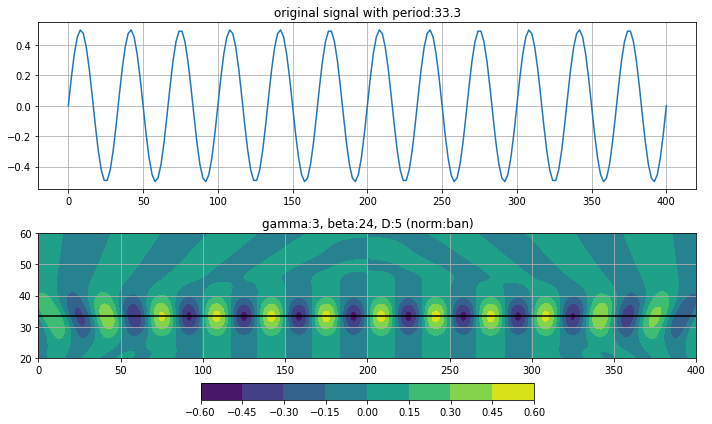

In [17]:
#creating data for testing and computing wavelet transform 
dt = 2
t = np.arange(0,200+1)*dt
amp = 0.5
f = 0.03
t_period = 1/f
x0 =amp*np.sin(2*np.pi*f*t);

#zero pad for boundaries 
x = zero_pad(x0)
M = len(x)
str='ban' #type of normalisation, bandpass or via energy 


#get wavelet shape 
ga = 3
be=24
K=1
D=5

#compute wavelet transform
WT = wavetrans(x0,ga,be,D,K,str)
fs = morsespace(ga,be,M,D)
t_scale = frequency_to_period(dt,fs)


fig, ax = plt.subplots(2,1,figsize=(10,6))

ax[0].plot(t,x0)
ax[0].set_title("original signal with period:{:.1f}".format(t_period))
ax[0].grid()

fig1 = ax[1].contourf(t,t_scale,np.transpose(WT))
fig.colorbar(fig1,ax=ax[1],orientation="horizontal",fraction=0.1)
ax[1].axhline(y=t_period,color="k")
ax[1].set_ylim(20,60)
ax[1].set_title("gamma:{}, beta:{}, D:{} (norm:{})".format(ga,be,D,str))
ax[1].grid()

plt.tight_layout()
plt.show()


#### Inverse formula using the $\delta$ function as the reconstruction wavelt ${\psi'}$ is just the sum of the real part of the wavelet transform over all scales - from Torrence & Compo (1998)

${x_n = \frac{\delta j \delta t^{1/2}}{C_{\delta}\psi_0(0)} \sum_{j=0}^J  \frac{R \{W_n(s_j) \}}{s_j^{1/2} }  }$

- ${\psi_0(0)}$ removes the energy scaling (note time-domain wavelet) - not known analytically for Morse
- ${s_j^{1/2}}$ converts the wavelet transform to an energy density
- $C_\delta$ is the reconstruction factor - not known for Morse


- here calculating the scaling factor: 
$ \frac{\delta j \delta t^{1/2}}{C_{\delta}\psi_0(0)} $ - ratio of max of original signal and max of $\sum_{j=0}^J  \frac{R \{W_n(s_j) \}}{s_j^{1/2} }$


In [18]:
#compare sum of WT with original signal to construct a scailing function
#tile over sj for easier multiplication
a, b = WT.shape
c = fs.size
if a == c:
    fs_tile = (np.ones([b, 1]) * fs).transpose()
elif b == c:
    fs_tile = np.ones([a, 1]) * fs

sum_WT = (np.real(WT)/(fs_tile**0.5)).sum(axis=1) #Taking real part since original signal is real

#compare max of signal with max of wavelet transform 
scaling_fact = np.max(sum_WT[50:100])/np.max(x0) # crude way for taking WT,away from edges

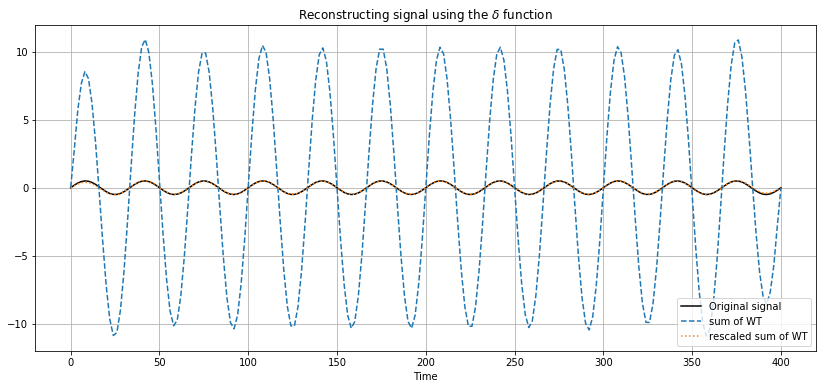

In [19]:
fig, ax = plt.subplots(1,figsize=(14,6))
plt.plot(t,x0,label="Original signal",color="k")
plt.plot(t,sum_WT,label="sum of WT",linestyle="--")
plt.plot(t,sum_WT*(scaling_fact**-1),label="rescaled sum of WT",linestyle=":") #using delta function for reverse wavelet
plt.xlabel("Time")
plt.legend(loc="lower right")
plt.title("Reconstructing signal using the $\delta$ function")

plt.grid()
plt.show()

#### Case 2: Using scaling factor on another signal (keep same Morse wavelet)
- set of scales unchanged
- $\delta j, \delta t, C_{\psi}, \psi $ are not changed


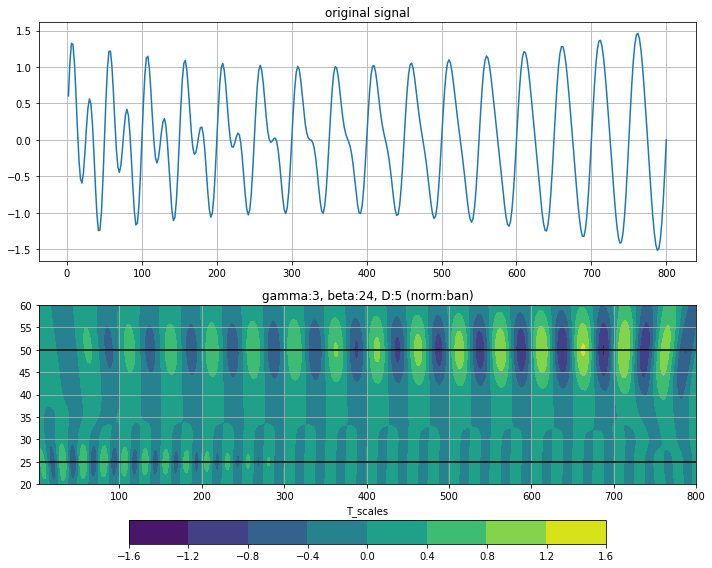

In [20]:
#creating data for testing and computing wavelet transform 
#option 2
dt = 2
t = np.arange(1,400+1)*dt
N=len(t)
amp1 = 0.5
f1 = 0.02
t1_period = 1/f1
x1 =amp1*np.sin(2*np.pi*f1*t)*np.exp(1.4e-3*t);

amp2 = 1
f2 = 0.04
t2_period = 1/f2
x2 = amp2*np.sin(2*np.pi*f2*t)*np.exp(-0.3e-2*t);

x0 = x1 + x2

#zero pad for boundaries 
x = zero_pad(x0)
M = len(x)
str='ban' #type of normalisation, bandpass or via energy 


#get wavelet shape 
ga = 3
be=24
K=1
D=5

#compute wavelet transform
WT = wavetrans(x0,ga,be,D,K,str)
fs = morsespace(ga,be,M,D)
t_scale = frequency_to_period(dt,fs)


fig, ax = plt.subplots(2,1,figsize=(10,8))

ax[0].plot(t,x0)
ax[0].set_title("original signal".format(t_period))
ax[0].grid()

fig1 = ax[1].contourf(t,t_scale,np.transpose(WT))
fig.colorbar(fig1,ax=ax[1],orientation="horizontal",fraction=0.1)
ax[1].axhline(y=t1_period,color="k")
ax[1].axhline(y=t2_period,color="k")

ax[1].set_ylim(20,60)
ax[1].set_title("gamma:{}, beta:{}, D:{} (norm:{})".format(ga,be,D,str))
ax[1].set_xlabel("Time")
ax[1].set_xlabel("T_scales")
ax[1].grid()

plt.tight_layout()
plt.show()

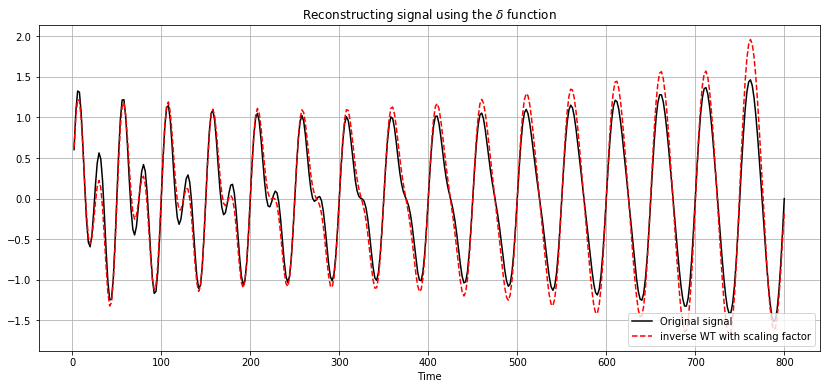

In [21]:
#compare sum of WT with original signal to construct a scailing function
#tile over fs (fs are the scales, defined as sj in other jupyter notebook) for easier multiplication
a, b = WT.shape
c = fs.size
if a == c:
    fs_tile = (np.ones([b, 1]) * fs).transpose()
elif b == c:
    fs_tile = np.ones([a, 1]) * fs

sum_WT = (np.real(WT)/(fs_tile**0.5)).sum(axis=1) #Taking real part since original signal is real

fig, ax = plt.subplots(1,figsize=(14,6))
plt.plot(t,x0,label="Original signal",color="k")
#plt.plot(t,sum_WT,label="sum of WT",linestyle="--")
plt.plot(t,sum_WT*(scaling_fact**-1),label="inverse WT with scaling factor",linestyle="--",color="r")
plt.xlabel("Time")
plt.legend(loc="lower right")
plt.title("Reconstructing signal using the $\delta$ function")

plt.grid()
plt.show()

***Remarks**
-  as expected scaling factor works 
- signal towards the end of the time series is not recoved correclty 
- Wavelet cannot recover growing signal with longer time period (as seen above in the WT figure)

*** small change of Morse wavelet (changing $\beta, \gamma, D$)*** - previously computed scaling factor should not work 

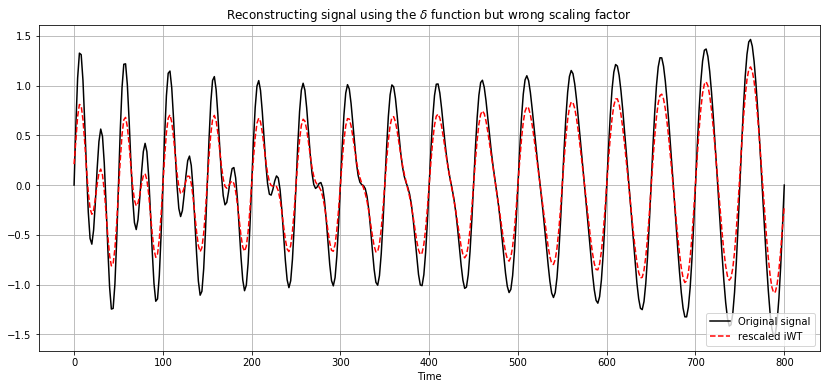

In [24]:
#creating data for testing and computing wavelet transform 
#option 2
dt = 2
t = np.arange(0,400+1)*dt
N=len(t)
amp1 = 0.5
f1 = 0.02
t1_period = 1/f1
x1 =amp1*np.sin(2*np.pi*f1*t)*np.exp(1.4e-3*t);

amp2 = 1
f2 = 0.04
t2_period = 1/f2
x2 = amp2*np.sin(2*np.pi*f2*t)*np.exp(-0.3e-2*t);

x0 = x1 + x2

#zero pad for boundaries 
x = zero_pad(x0)
M = len(x)
str='ban' #type of normalisation, bandpass or via energy 


#get wavelet shape 
ga = 2
be=14
K=1
D=3

#compute wavelet transform
WT = wavetrans(x0,ga,be,D,K,str)
fs = morsespace(ga,be,M,D)
t_scale = frequency_to_period(dt,fs)


#compare sum of WT with original signal to construct a scailing function
#tile over sj for easier multiplication
a, b = WT.shape
c = fs.size
if a == c:
    fs_tile = (np.ones([b, 1]) * fs).transpose()
elif b == c:
    fs_tile = np.ones([a, 1]) * fs

sum_WT = (np.real(WT)/(fs_tile**0.5)).sum(axis=1) #Taking real part since original signal is real

fig, ax = plt.subplots(1,figsize=(14,6))
plt.plot(t,x0,label="Original signal",color="k")
#plt.plot(t,sum_WT,label="sum of WT",linestyle="--")
plt.plot(t,sum_WT*(scaling_fact**-1),label="rescaled iWT",linestyle="--",color="r")
plt.xlabel("Time")
plt.legend(loc="lower right")
plt.title("Reconstructing signal using the $\delta$ function but wrong scaling factor")

plt.grid()
plt.show()

*** All previous signals have been recovered using the $\delta$ function as inverse wavelet *** 

#### General reconstruction/inversion formula
- when using same wavelet ($\psi$) for decomposition and reconstruction

$f(t) = C_{\psi}^{-1} \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} a^{-2} \big(W_{\psi}f\big)(a,b) \ \psi_{a,b}(t) \ db da$

- note here scaling factor is all in $C_\psi^{-1}$
- finding scaling factor by considering a $\delta$ function as input 

- steps to perform:
        1)form morse wavelet
        2) use delta function as input signal, to find scaling factor
        3) determine scaling factor for specific morse wavelets
        4) recover signal with same Morse wavelet (for both forward and backward)
        5) to recover signal, convolution in time domain needed (Morse needed in time domain)

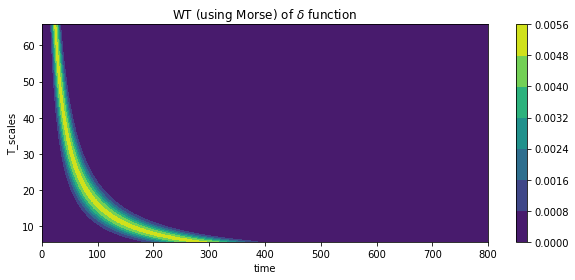

In [23]:
#compute psif
#x = zero_pad(x0)
x=x0
M = len(x) #length of padded data
fs = morsespace(ga,be,M,D)
t_scale = frequency_to_period(dt,fs)
L=len(fs)

#compute Morse wavelet (parameters defined above)
psif = morsewave(M,K,ga,be,fs,str)
psif = np.conj(psif) 
 
WT_delta = (1/M)*psif

#plot to see if WT of delta function makes sense/is correct 
fig, ax = plt.subplots(1,figsize=(10,4))
plt.contourf(t,t_scale,np.transpose(WT_delta))
plt.title("WT (using Morse) of $\delta$ function")
plt.xlabel("time")
plt.ylabel("T_scales")
plt.colorbar()
plt.show()


### Finding reconstruction factor
#### Recall our computed scalng factor is  $ \frac{\delta j \delta t^{1/2}}{C_{\delta}\psi_0(0)} $
- if a different wavelet (that is not a $\delta$ function) is used - the separate values defined above ($\delta_j, \psi$) will have to be known


In [ ]:
# computing dj (from fs computed from morsespace)

In [ ]:
# computing c_delta

In [ ]:
# computing psi (wavelet in time domain) 

In [ ]:
#defining scales (here using Mexican hat)

dj = 0.4              # largest value for Mexican hat (1.4)
n0 = len(x0)                     # Original signal length 
N = 2 ** (int(np.log2(n0)) + 1)  # Next higher power of 2 (for more efficient computation)
s0 = 2 * dt                      # Smallest resolvable scale:
J = int(np.log2(N * dt / s0) / dj)     # Number of scales

sj = s0 * 2 ** (np.arange(0, J+1) * dj) # The scales


In [ ]:
J

In [ ]:
low=(5,N) #5 is the packing number (p) 
high=(0.1,np.pi)
fhigh = min(high[1],morsehigh(ga,be,high[0]))
flow = max(0,morsespace_low(ga,be,low[0],low[1]))